In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import torch
from plaid.datasets import FastaDataset, MetadataParser, NUM_FUNCTION_CLASSES, NUM_ORGANISM_CLASSES
import numpy as np

val_fasta = '/data/lux70/data/pfam/val.fasta'
ds = FastaDataset(val_fasta)
parser = MetadataParser()

100%|██████████| 1.56G/1.56G [00:06<00:00, 266MB/s]
100%|██████████| 1.56G/1.56G [00:08<00:00, 187MB/s]


## Parse FASTA to DataFrame

In [16]:
all_pfam_ids = []
all_organisms = []
all_sequences = []

from tqdm.notebook import trange
import math

for i in trange(len(ds)):
    header, sequence = ds[i]
    pfam_id = parser.header_to_pfam_id(header)
    organism = parser.header_to_organism(header)

    all_pfam_ids.append(pfam_id)
    all_organisms.append(organism)
    all_sequences.append(sequence)

  0%|          | 0/8596167 [00:00<?, ?it/s]

In [17]:
print(len(all_pfam_ids))
print(len(all_organisms))
print(len(all_sequences))

8596167
8596167
8596167


In [21]:
# print(len(np.unique(all_pfam_ids)))
# print(len(np.unique(all_organisms)))
# print(len(np.unique(all_sequences)))

In [19]:
import pandas as pd

df = pd.DataFrame({
    "pfam_id": all_pfam_ids,
    "organism": all_organisms,
    "sequence": all_sequences
})

In [23]:
# outpath = "/data/lux70/data/pfam/val.parquet"
# df.to_parquet(outpath)

In [13]:
# df = pd.read_parquet("/data/lux70/data/pfam/val.parquet") 

In [22]:
df.head()

,pfam_id,organism,sequence
0,PF08450,9PROT,WLEGPAWSSEGRFLVLSDVIQSKALRYIWETGEITQFRPEGYAANG...
1,PF08450,9GAMM,GTEGPIAAPDGSFLFTETRANRITKIAPDNTISTFLENSNGSNGLA...
2,PF08450,9BURK,WSEGPVWFGDGRCLLWSDIPNNRILRWDEESGQVGVFRKPSDNANG...
3,PF08450,9GAMM,VAPAPNGLVWYTAQKAGALGILDPSNGDVRHIKLGQGSAPHGVIQG...
4,PF08450,9ACTN,YPEGVAWDPTRRAFLVGSALKGTLSVIRLDGTVKELAPSIGMVSTL...


## Merge Metadata

In [24]:
from plaid.datasets import MetadataParser
metadata_parser = MetadataParser()

In [25]:
metadata_parser.go_metadata

,pfam_id,GO_id,GO_term,GO_level,count,GO_idx
0,PF00001,GO:0004930,G protein-coupled receptor activity,function,11,0
1,PF00002,GO:0004930,G protein-coupled receptor activity,function,11,0
2,PF00003,GO:0004930,G protein-coupled receptor activity,function,11,0
3,PF00004,GO:0016887,ATP hydrolysis activity,function,15,1
4,PF00005,GO:0016887,ATP hydrolysis activity,function,15,1
...,...,...,...,...,...,...
5207,PF21665,GO:0009306,protein secretion,process,11,123
5208,PF21729,GO:0045492,xylan biosynthetic process,process,1,2218
5209,PF21730,GO:0070072,vacuolar proton-transporting V-type ATPase com...,process,4,1706
5210,PF21767,GO:0005515,protein binding,function,122,10


In [10]:
metadata_parser.go_metadata.GO_level.unique()

array(['function', 'process', 'component'], dtype=object)

In [26]:
tmp = df.merge(metadata_parser.go_metadata, on="pfam_id", how="left")

In [27]:
tmp.head()

,pfam_id,organism,sequence,GO_id,GO_term,GO_level,count,GO_idx
0,PF08450,9PROT,WLEGPAWSSEGRFLVLSDVIQSKALRYIWETGEITQFRPEGYAANG...,NaN,NaN,NaN,NaN,NaN
1,PF08450,9GAMM,GTEGPIAAPDGSFLFTETRANRITKIAPDNTISTFLENSNGSNGLA...,NaN,NaN,NaN,NaN,NaN
2,PF08450,9BURK,WSEGPVWFGDGRCLLWSDIPNNRILRWDEESGQVGVFRKPSDNANG...,NaN,NaN,NaN,NaN,NaN
3,PF08450,9GAMM,VAPAPNGLVWYTAQKAGALGILDPSNGDVRHIKLGQGSAPHGVIQG...,NaN,NaN,NaN,NaN,NaN
4,PF08450,9ACTN,YPEGVAWDPTRRAFLVGSALKGTLSVIRLDGTVKELAPSIGMVSTL...,NaN,NaN,NaN,NaN,NaN


In [29]:
len(tmp.GO_id.unique())

525

In [30]:
orgdf = metadata_parser.organism_metadata
orgdf = orgdf.rename({"organism_id":"organism"},axis=1)
orgdf.head()

,organism_index,organism,counts
0,0,SYNS9,2126
1,1,SCHAZ,4805
2,2,9ENTE,108317
3,3,APHAT,14121
4,4,9GAMM,2601336


In [31]:
tmp = tmp.merge(orgdf, on="organism", how="left")

In [32]:
tmp = tmp.rename({"counts":"organism_counts", "count":"GO_counts"},axis=1)

In [33]:
tmp.head()

,pfam_id,organism,sequence,GO_id,GO_term,GO_level,GO_counts,GO_idx,organism_index,organism_counts
0,PF08450,9PROT,WLEGPAWSSEGRFLVLSDVIQSKALRYIWETGEITQFRPEGYAANG...,NaN,NaN,NaN,NaN,NaN,40,1199947
1,PF08450,9GAMM,GTEGPIAAPDGSFLFTETRANRITKIAPDNTISTFLENSNGSNGLA...,NaN,NaN,NaN,NaN,NaN,4,2601336
2,PF08450,9BURK,WSEGPVWFGDGRCLLWSDIPNNRILRWDEESGQVGVFRKPSDNANG...,NaN,NaN,NaN,NaN,NaN,16,1579077
3,PF08450,9GAMM,VAPAPNGLVWYTAQKAGALGILDPSNGDVRHIKLGQGSAPHGVIQG...,NaN,NaN,NaN,NaN,NaN,4,2601336
4,PF08450,9ACTN,YPEGVAWDPTRRAFLVGSALKGTLSVIRLDGTVKELAPSIGMVSTL...,NaN,NaN,NaN,NaN,NaN,31,3774426


In [34]:
len(tmp.organism_counts.unique())

2565

## Clean-up

In [35]:
tmp['GO_idx'][tmp.GO_idx.isna()] = NUM_FUNCTION_CLASSES

/tmp/ipykernel_2977828/2821481273.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tmp['GO_idx'][tmp.GO_idx.isna()] = NUM_FUNCTION_CLASSES
/tmp/ipykernel_2977828/2821481273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a c

In [36]:
tmp['GO_idx'] = tmp.GO_idx.astype(int)
tmp['GO_id'] = tmp['GO_id'].fillna("")
tmp['GO_term'] = tmp['GO_term'].fillna("")
tmp['GO_level'] = tmp['GO_level'].fillna("")
tmp['seq_len'] = tmp.sequence.str.len()

In [47]:
tmp.head()

,pfam_id,organism,sequence,GO_id,GO_term,GO_level,GO_counts,GO_idx,organism_index,organism_counts,seq_len
0,PF08450,9PROT,WLEGPAWSSEGRFLVLSDVIQSKALRYIWETGEITQFRPEGYAANG...,,,,NaN,2219,40,1199947,293
1,PF08450,9GAMM,GTEGPIAAPDGSFLFTETRANRITKIAPDNTISTFLENSNGSNGLA...,,,,NaN,2219,4,2601336,252
2,PF08450,9BURK,WSEGPVWFGDGRCLLWSDIPNNRILRWDEESGQVGVFRKPSDNANG...,,,,NaN,2219,16,1579077,259
3,PF08450,9GAMM,VAPAPNGLVWYTAQKAGALGILDPSNGDVRHIKLGQGSAPHGVIQG...,,,,NaN,2219,4,2601336,216
4,PF08450,9ACTN,YPEGVAWDPTRRAFLVGSALKGTLSVIRLDGTVKELAPSIGMVSTL...,,,,NaN,2219,31,3774426,211


<Axes: >

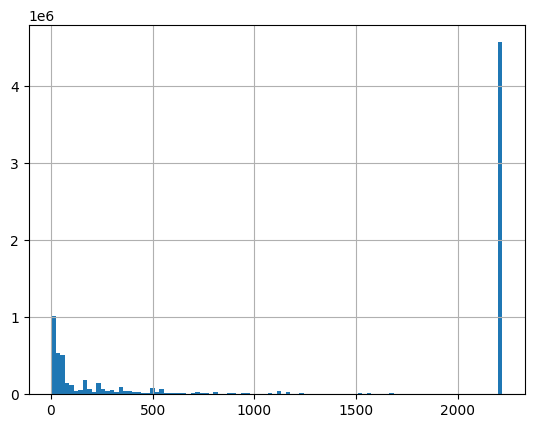

In [45]:
tmp.GO_idx.hist(bins=100)

<Axes: >

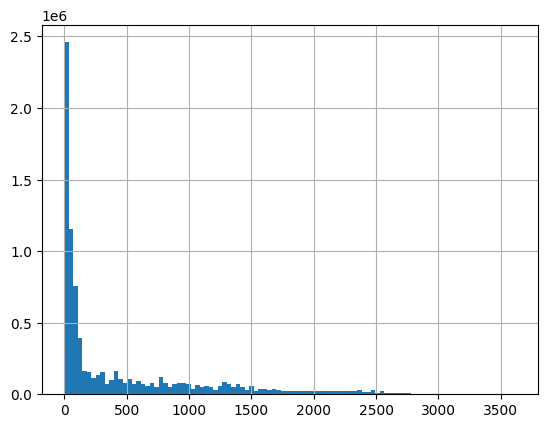

In [46]:
tmp.organism_index.hist(bins=100)

In [48]:
# outpath = "/data/lux70/data/pfam/val.parquet"
# tmp.to_parquet(outpath)

In [98]:
values, counts = np.unique(tmp2.GO_term, return_counts=True)

In [109]:
tmp3 = pd.DataFrame(
    {
        "GO_term": values,
        "counts": counts
    }
)

In [112]:
tmp3 = tmp3.sort_values(by="counts")

In [114]:
tmp3.to_csv("/data/lux70/data/pfam/val_go_counts.csv", index=False)

In [175]:
tmp2[tmp2.GO_term == "metal ion transport"].shape

(10852, 10)

In [176]:
import cheap

In [180]:
from cheap.pretrained import load_pretrained_model
from cheap.pretrained import load_model_from_id
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32

hourglass = CHEAP_pfam_shorten_2_dim_32()

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.


In [181]:
from cheap.esmfold import esmfold_v1_embed_only

In [182]:
esmfold_embed_only = esmfold_v1_embed_only()

Creating ESMFold embedding only model...
ESMFold embedding only model created in 32.45 seconds


In [184]:
from cheap.utils import LatentScaler

scaler = LatentScaler()

# Read

In [11]:
import pandas as pd

df = pd.read_parquet("/data/lux70/data/pfam/val_shard_info.parquet")

In [12]:
df.shape

(93753102, 11)

In [13]:
df.head()

,GO_idx,organism_index,local_paths,sample_ids,organism_id,organism_counts,pfam_id,GO_id,GO_term,GO_level,GO_counts
0,2130,472,/data/lux70/data/pfam/compressed/j1v1wv6w/val/...,sample001462,9ENTR,85933,PF15894,GO:0046325,negative regulation of glucose import,process,1
1,2130,215,/data/lux70/data/pfam/compressed/j1v1wv6w/val/...,sample001463,SERS3,4700,PF15894,GO:0046325,negative regulation of glucose import,process,1
2,2130,472,/data/lux70/data/pfam/compressed/j1v1wv6w/val/...,sample001464,9ENTR,85933,PF15894,GO:0046325,negative regulation of glucose import,process,1
3,2130,472,/data/lux70/data/pfam/compressed/j1v1wv6w/val/...,sample001465,9ENTR,85933,PF15894,GO:0046325,negative regulation of glucose import,process,1
4,2130,4,/data/lux70/data/pfam/compressed/j1v1wv6w/val/...,sample001466,9GAMM,2601336,PF15894,GO:0046325,negative regulation of glucose import,process,1


In [ ]:
df